In [1]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# First we load the data

In [2]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [3]:
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H228')

C:\Users\dosju\AppData\Local\Temp\ipykernel_20736\4248378027.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')


# Then we explore the series, with distribution, the ACF, PACF, moving avg, decomposition and descriptive statistics

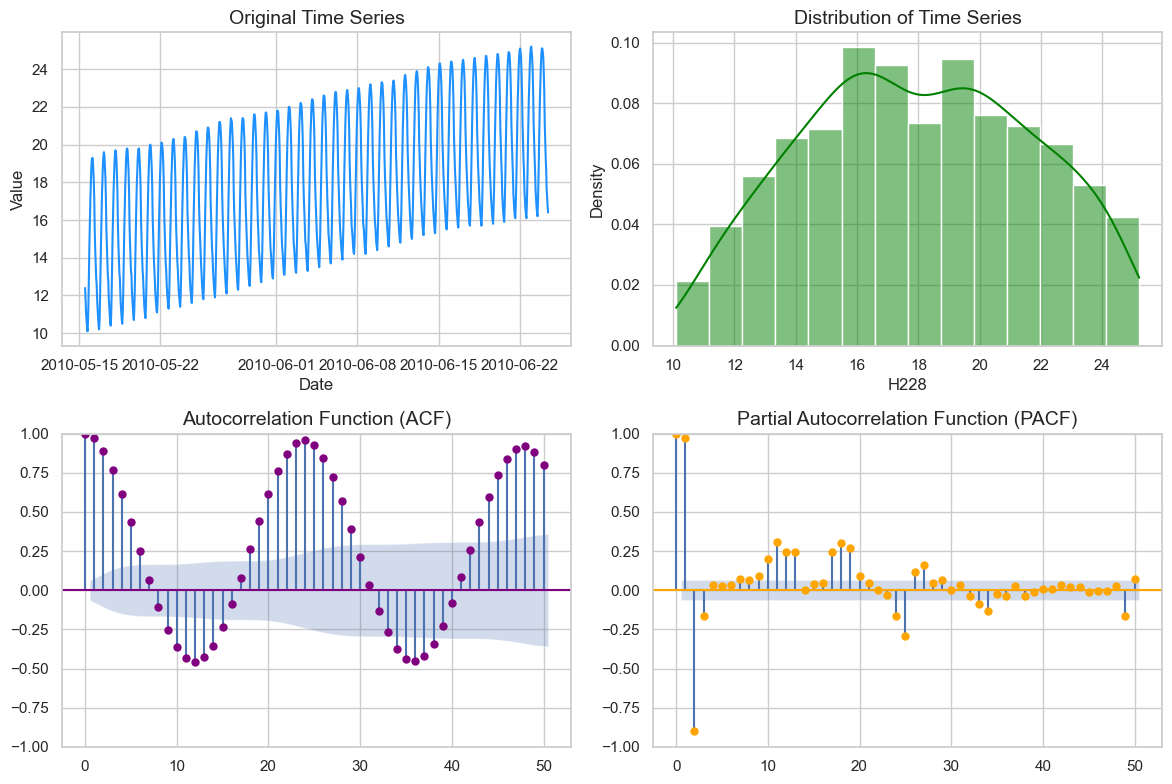

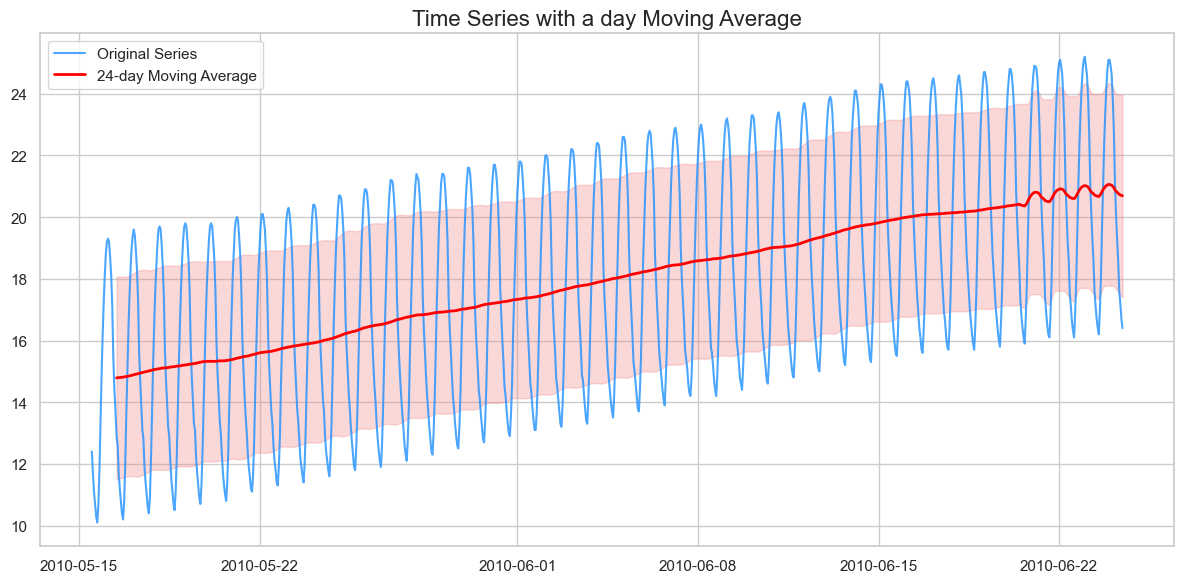

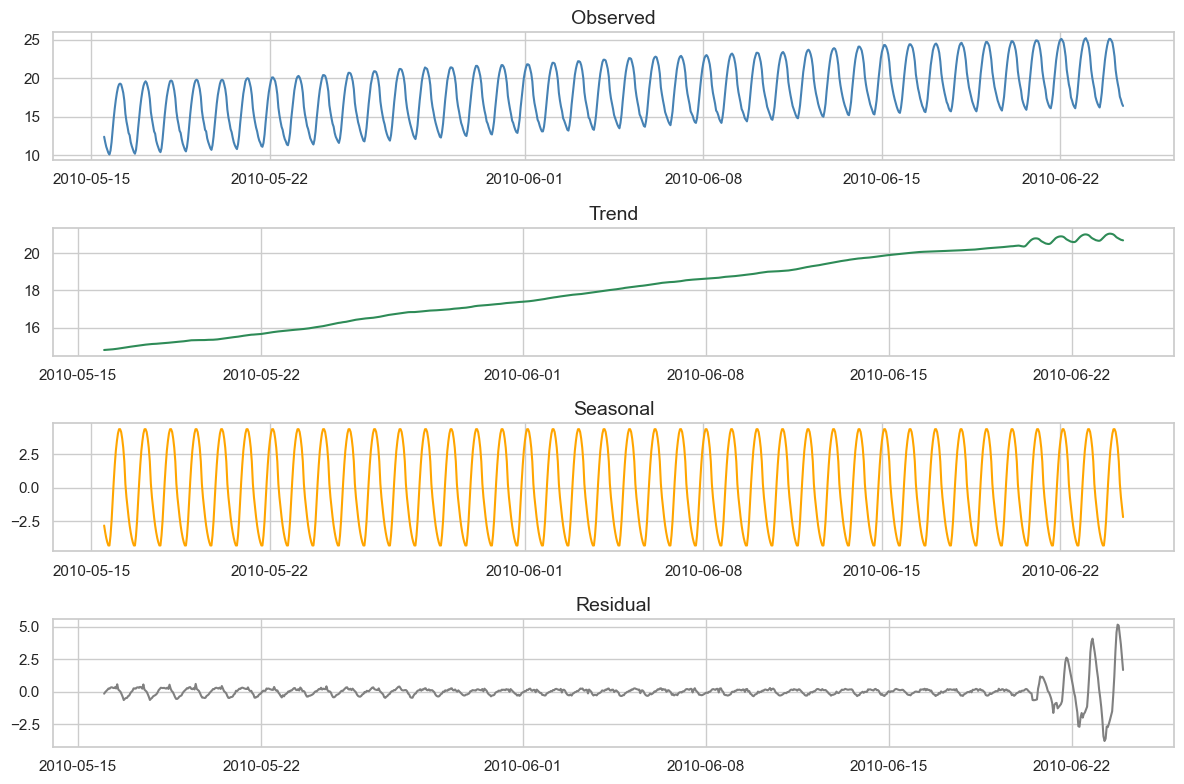

Descriptive Statistics:
count    960.000000
mean      17.977396
std        3.711648
min       10.100000
25%       15.200000
50%       17.900000
75%       20.900000
max       25.200000
Name: H228, dtype: float64

Shapiro-Wilk Test p-value: 1.2987612233385053e-10
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -1.1984878942286918
p-value: 0.6742458431630524
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [4]:
univariate_data_analysis(ts)

- **Distribution:**  
  The histogram appears like **bimodal** and not normal with a mean around 17.98, suggesting as in the previous ts, multiple states, also the Shapiro-Wilk sugests no normaility

- **Autocorrelation:**  
  A clear pattern emerges **every 24 hours**, reinforcing the fact that the series exhibits **daily seasonality**.  

- **Partial Autocorrelation:**  
  Significant spikes at the **first and second lags** indicate a **strong autoregressive component**. This means that **previous observations** have a **major impact** on the next ones.  

- **ADF Test:**  
  The test suggests that the series is **non-stationary**, aligning with the **seasonal patterns** previously observed.  

- **Moving Average Analysis:**  
  The daily moving average captures the underlying trend while smoothing out the daily fluctuations, showing a consistent upward trend.


# Then We Split the Data and Model  

The `time_series_forecasting` function applies a **Min-Max scaling transformation** to help the model converge faster. It then:  

1. **Creates daily sequences**  
2. **Reshapes the data** for each specific architecture  
3. **Trains 12 different architectures** (3 per model) with **early stopping** for 200 epochs  
4. **Selects the best model** based on the lowest **MAE**  
5. **Plots its predictions** and comparisons with the test data  

This ensures we find the most effective model for the given time series data.  


Train: 624, Validation: 144, Test: 144


C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MLP Model 1 MAE: 0.38513504028320267
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MLP Model 2 MAE: 1.968466094334921
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023EE225E0C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
MLP Model 3 MAE: 0.39039955139160115
4/4 ━━━━━━━━

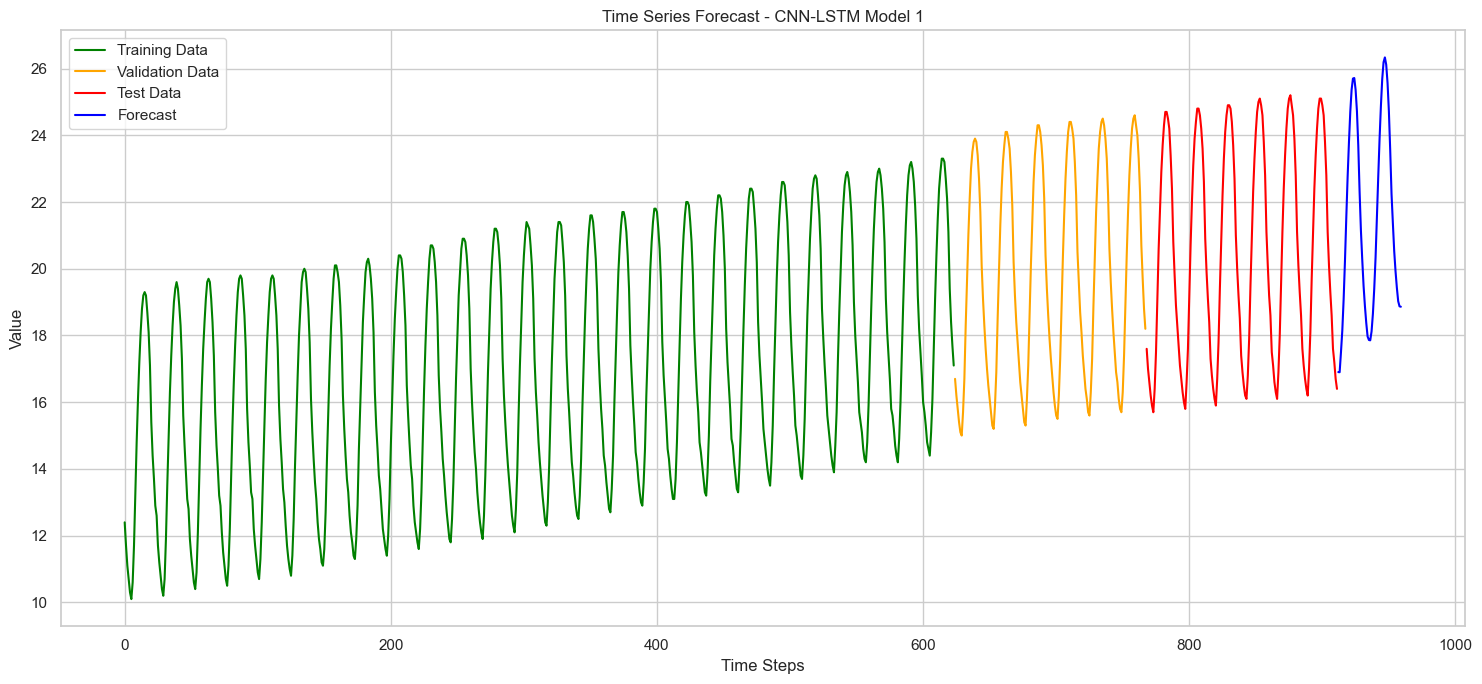

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


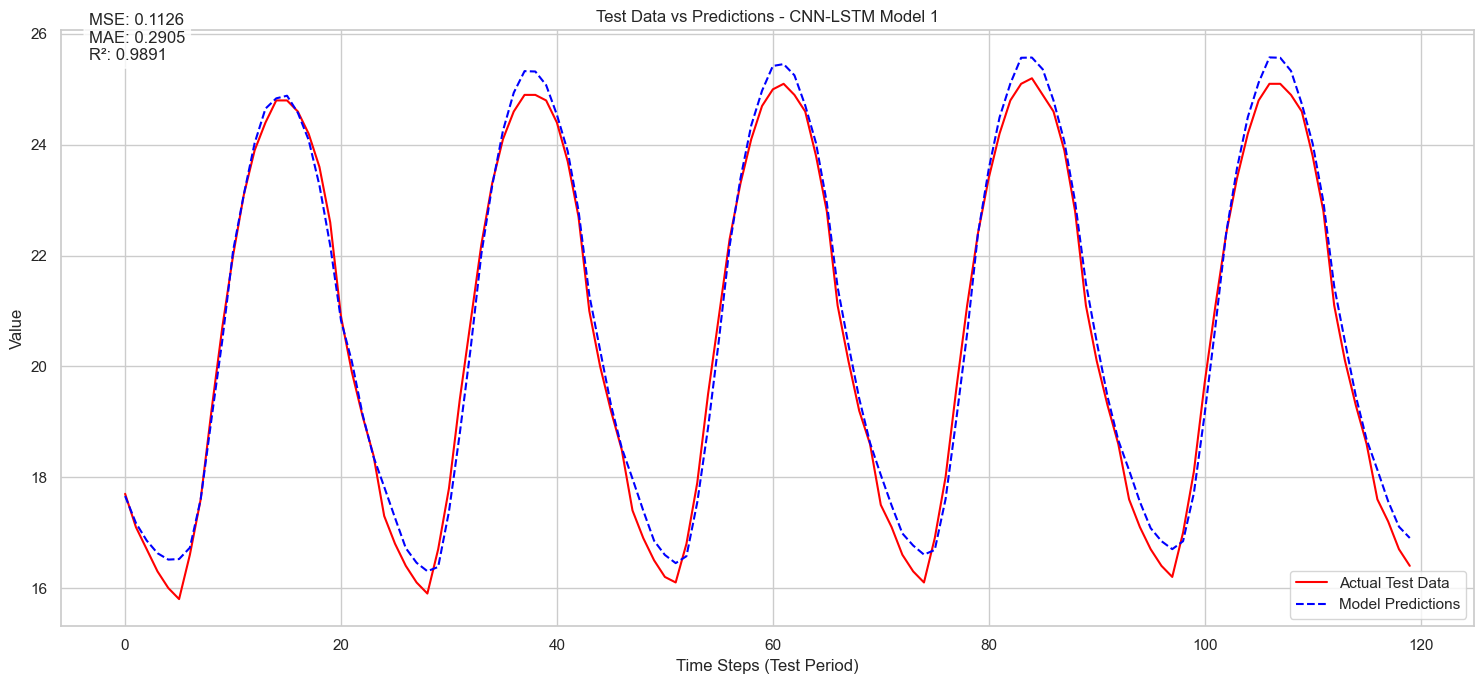


Model Performance Comparison:
      Model Type  Mean Absolute Error
CNN-LSTM Model 1             0.290512
     MLP Model 1             0.385135
     MLP Model 3             0.390400
     CNN Model 1             0.420899
    LSTM Model 3             0.460510
    LSTM Model 1             0.501937
CNN-LSTM Model 3             0.533970
    LSTM Model 2             0.537551
     CNN Model 2             0.574195
CNN-LSTM Model 2             0.590721
     MLP Model 2             1.968466
     CNN Model 3             3.165236


In [5]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

The best model was a single **LSTM** with:
- **1 LSTM layer** with **50 neurons**
- **1 Dense output layer** with **1 neuron**
- **Activation function:** ReLU

In [6]:
best_model['best_model'].summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 22, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 11, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,398 (200.78 KB)

 Trainable params: 17,132 (66.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 34,266 (133.86 KB)

# Optuna

After that, we select the model that gave the best results and optimize it with **Optuna** for:  
- **Learning rate**  
- **Activation functions**  
- **Number of layers**  
- **Number of units per layer**  
- **Optimizer**  

The function is designed to **adapt** and tune the best model architecture **regardless of its type**, as different models can perform better depending on the series. Our goal is to achieve the **optimal performance** possible.  

The experiment runs for **100 trials**, then the results are **de-scaled** and plotted against the **test set**, allowing us to compare with the previous model.  


[I 2025-04-03 01:24:44,316] A new study created in memory with name: no-name-717082f3-2533-49d2-ab71-abbfe51984f5
c:\Users\dosju\Downloads\Examen2NL\pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-03 01:25:29,073] Trial 0 finished with value: 0.014110040850937366 and parameters: {'optimizer': 'adam', 'learning_r

Best MLP Model Optimization Results:
  Number of trials: 200
  Best trial value (MAE): 0.004390878602862358
  Best hyperparameters:
    optimizer: adam
    learning_rate: 0.004970023012610042
    activation: tanh
    n_layers: 2
    neurons_0: 134
    neurons_1: 128
    dropout_1: 0.02254728020167145
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

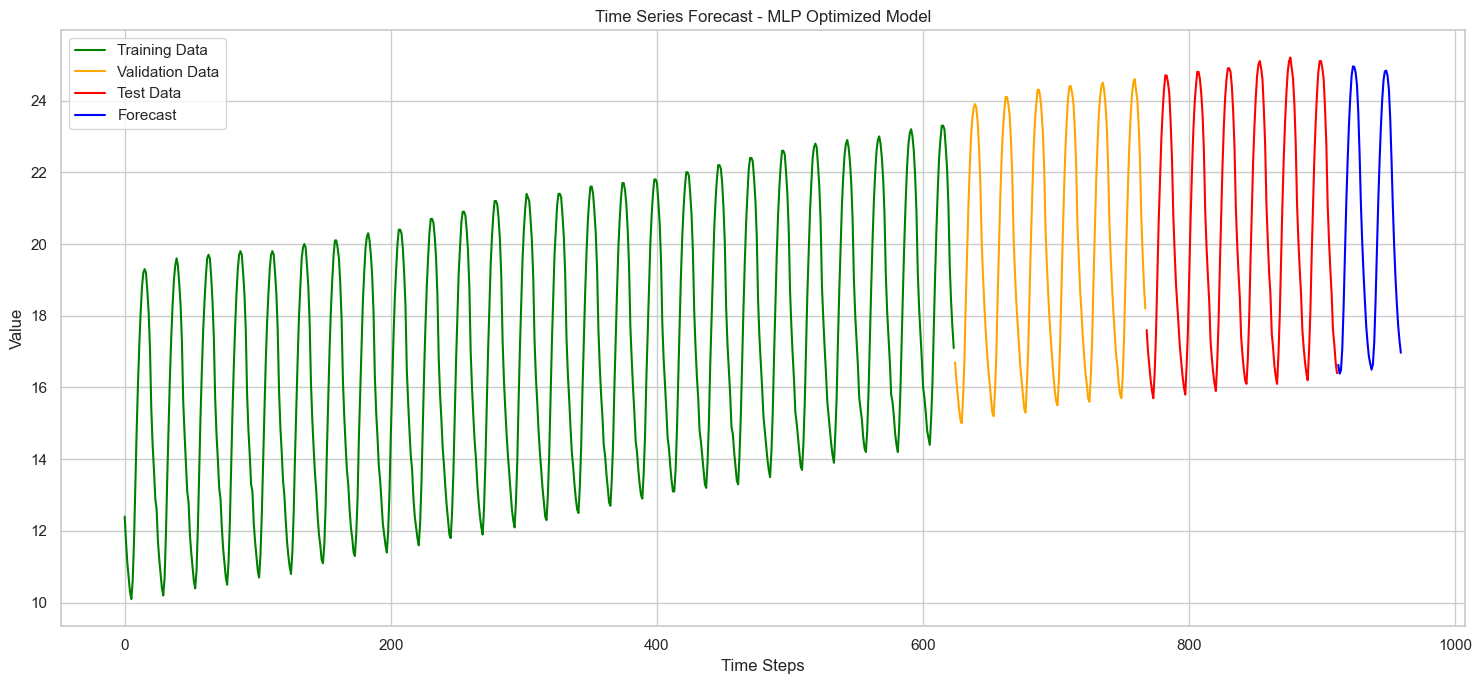


Test Data Prediction Analysis:


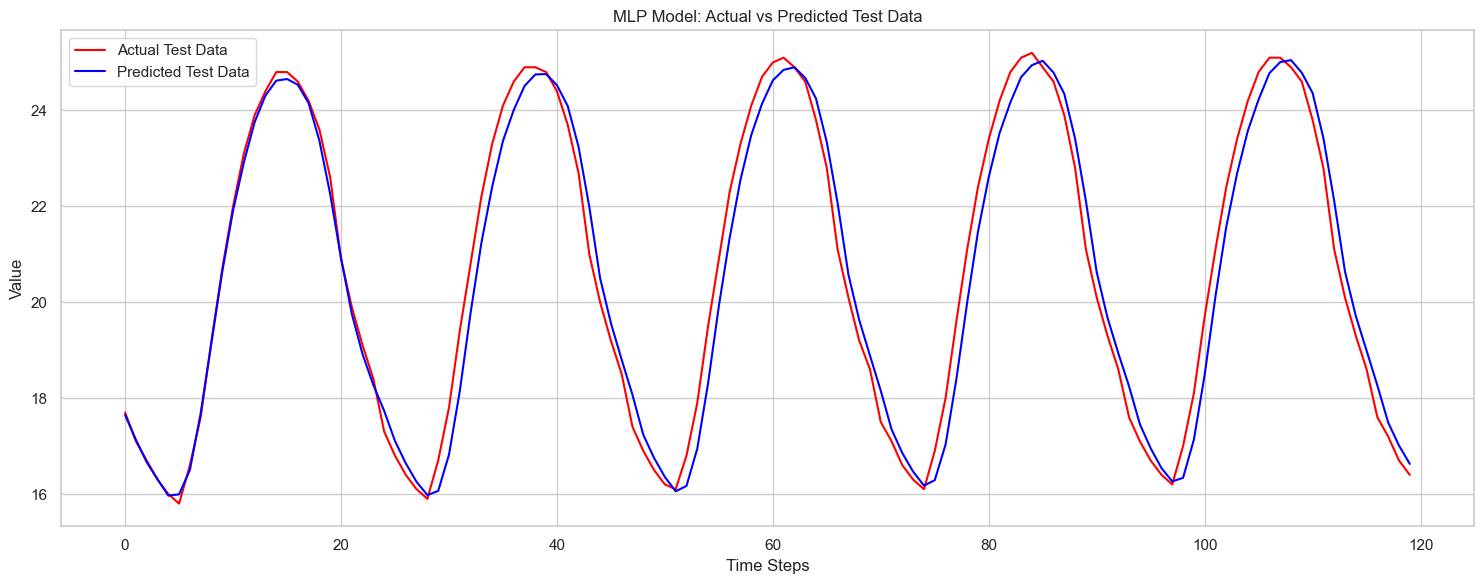


Model Performance Metrics:
Mean Absolute Error (MAE): 0.44282176971435544
Mean Squared Error (MSE): 0.3089791719236667


In [7]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']

## Best MLP Model Optimization Results - Improved Model

### Summary
- **Number of trials:** 200
- **Best trial value (MAE):** 0.004735623020678759
- **Best hyperparameters:**  
  - **Optimizer:** Adam  
  - **Learning rate:** 0.0008420183450492546  
  - **Activation:** ELU  
  - **Number of layers:** 2  
  - **Neurons per layer:**  
    - **Layer 0:** 169  
    - **Layer 1:** 126  
  - **Dropout (Layer 1):** 9.97854530457433e-05  


We achieved a **0.0047 MAE**, which indicates a stunning model outperforming by far the previous model which wasnt even bad
